In [34]:
%load_ext autoreload
%autoreload 2
import chess
import chess.engine
from collections import defaultdict
import random
import numpy as np
from sarfa_core import computeSaliencyUsingSarfa
from sys import platform as _platform
from utils import get_all_pos, get_move_obj
from utils import pos_to_index_mapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_engine(engine_file = './stockfish_15_x64_avx2'):
    chess_engine = chess.engine.SimpleEngine.popen_uci(engine_file)
    return chess_engine

def q_values(board, candidate_actions, selected_action, multipv=3, runtime=2.0, use_optimal_action=False):
    options = chess_engine.analyse(board, chess.engine.Limit(time=runtime), multipv=multipv)
    
    score_per_move = defaultdict(int)

    for option in options:
        is_white_move = option['score'].turn
        score = option['score'].white() if is_white_move else option['score'].black()
        
        curr_action = str(option["pv"][0])
        if option['score'].is_mate():
            score = 40 if '+' in str(score) else -40
        else:
            score = round(score.cp/100.0, 2)
        
        score_per_move[curr_action] = score

    q_vals = {}
    optimal_action = None
    best_q_val = float('-inf')
    for valid_move in candidate_actions:
        q_vals[str(valid_move)] = score_per_move[str(valid_move)]

        if q_vals[str(valid_move)] > best_q_val:
            best_q_val = q_vals[str(valid_move)]
            optimal_action = str(valid_move)
        
    if use_optimal_action:
        selected_action = optimal_action

    return q_vals, selected_action

In [3]:
def removal_perturb(board, position):
    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece or piece == chess.Piece(chess.KING, chess.WHITE) or piece == chess.Piece(chess.KING, chess.BLACK):
        return
    
    perturbed_board = board.copy()
    perturbed_board.remove_piece_at(position)
    if perturbed_board.was_into_check():
        return 
    
    return [perturbed_board], position

def empty_space_perturb(board, position):
    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece:
        perturbed_board = board.copy()
        new_piece = chess.Piece(chess.PAWN, chess.WHITE) if board.turn else chess.Piece(chess.PAWN, chess.BLACK)
        perturbed_board.set_piece_at(position, new_piece)
        if perturbed_board.was_into_check():
            return
        
        return [perturbed_board], position
    else:
        return

# def opp_piece_perturb(board, position):
#     position = get_move_obj(position)
#     piece = board.piece_at(position)
#     if not piece:
#         return
    
#     if piece.color and board.turn:
        
    
    

In [42]:
#########################################
num_actions = 100
runtime = 1.5
use_optimal_action = True
allow_defense = False
#########################################

# Bishop Pins Rooks
# FEN = "5rk1/6pp/1B1r4/5p2/8/2P5/PP6/1K4R1 w - - 0 1"
# action = "b6c5"

# Bishop Checks on Open Diagonal - showcases empty space perturbation
# FEN = "6N1/1pkb4/p3pQ1p/2P1P3/3P4/4q1P1/PP5P/5R1K b - - 0 33"
# action = "d7c6"

# Backrank Check protected by Knight - identifying defensive pieces?
# FEN = "6k1/1n3ppp/8/8/8/8/7P/1K1R4 w - - 0 1"
# action = "d1d8"

# More complicated Backrank Check - identify defensive pieces
# FEN = "3r2kr/5ppp/8/1n6/3B3R/8/1PP4P/RK6 b - - 0 1"
# action = "d8d4"

# Example from SARFA paper - testing relationships
# FEN = '3r1rk1/1b2bpp1/p3p2p/R3N3/2pB1P2/2P3qP/PP1Q2P1/5RK1 b - - 0 1'
# action = 'd8d4'

# Random Complicated Position
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
action = ''


chess_engine = get_engine()
board = chess.Board(FEN)
legal_moves = set(list(board.legal_moves))
perturbation_to_qvals = dict()
perturbation_to_saliency = dict()

board_positions = get_all_pos()
for pos in board_positions:
    # can substitute for any perturb function
    perturbed_state = removal_perturb(board, pos)
    # perturbed_state = empty_space_perturb(board, pos)
    if perturbed_state is None:
        continue

    perturbed_boards, _ = perturbed_state

    # list of perturbed boards allows for perturb function to test different 
    # perturbations on the same state
    for i, perturbed_board in enumerate(perturbed_boards):
        new_legal_moves = perturbed_board.legal_moves
        candidate_actions = legal_moves.intersection(set(new_legal_moves))

        if not use_optimal_action and chess.Move.from_uci(action) not in candidate_actions:
            continue
        
        q_vals_before, selected_action = q_values(board, candidate_actions, action, multipv=num_actions, 
                                            runtime=runtime, use_optimal_action=use_optimal_action)
        q_vals_after, selected_action = q_values(perturbed_board, candidate_actions, selected_action, 
                                            multipv=num_actions, runtime=runtime)
    
        saliency, dP, K, QmaxAnswer, _, _ = computeSaliencyUsingSarfa(selected_action, q_vals_before, q_vals_after, allow_defense_check=allow_defense)
        saliency = 0 if abs(saliency) < 0.001 else saliency

        saliency_type = ""
        if allow_defense and dP < 0 and abs(dP) > 0.1:
            saliency_type = "Defensive "
            saliency = abs(saliency)
        
        perturbation_to_saliency[pos] = abs(saliency)
        perturbation_to_qvals[pos] = [q_vals_before, q_vals_after]
        print(f'Perturbed Board {i}, Perturbed position: {pos}, Action: {selected_action}, {saliency_type}Saliency: {saliency}')


Perturbed Board 0, Perturbed position: a2, Action: d3d8, Saliency: 0.2831121407572447
Perturbed Board 0, Perturbed position: a3, Action: d3d8, Saliency: 0.25171258920020256
Perturbed Board 0, Perturbed position: a6, Action: d3d8, Saliency: 0
Perturbed Board 0, Perturbed position: b3, Action: d3d8, Saliency: 0.4196928721330277
Perturbed Board 0, Perturbed position: b4, Action: d3d6, Saliency: 0.22790222963301932
Perturbed Board 0, Perturbed position: c4, Action: d3d8, Saliency: 0
Perturbed Board 0, Perturbed position: c5, Action: d3d6, Saliency: 0.210335606435118
Perturbed Board 0, Perturbed position: c6, Action: d3d6, Saliency: 0.08582185978990685
Perturbed Board 0, Perturbed position: c7, Action: d3d8, Saliency: 0
Perturbed Board 0, Perturbed position: d1, Action: d3d8, Saliency: 0.31317696101944664
Perturbed Board 0, Perturbed position: d2, Action: d3d8, Saliency: 0.31725409515354525
Perturbed Board 0, Perturbed position: d3, Action: d2f2, Saliency: 0.036796546506073786
Perturbed Boa

In [5]:
def dfs(curr, cluster, graph):
    if curr not in cluster:
        cluster.add(curr)
        for neighbor in graph[curr]:
            dfs(neighbor, cluster, graph)

In [10]:
################################
kD_threshold = 0.3
################################

relationship_graph = defaultdict(set)
directed_graph = defaultdict(set)

# Compute most important pair of pieces for each piece
for pos1 in perturbation_to_qvals.keys():
    q_val_before, q_val_after = perturbation_to_qvals[pos1]
    
    action_dist_before = defaultdict(list)
    action_dist_after = defaultdict(list)
    for action in q_val_before.keys():
        pos2 = action[:2]
        action_dist_before[pos2].append(q_val_before[action])
        action_dist_after[pos2].append(q_val_after[action])
    
    other_positions = []
    kl_divergences = []
    for pos2 in action_dist_before:
        # Softmax
        a_b = action_dist_before[pos2]
        a_b = np.exp(a_b) / np.sum(np.exp(a_b))
        a_b = np.clip(a_b, 1e-10, 1)

        a_a = action_dist_after[pos2]
        a_a = np.exp(a_a) / np.sum(np.exp(a_a))
        a_a = np.clip(a_a, 1e-10, 1)

        # KL-Divergence
        kD = np.sum(a_b * np.log(a_b / a_a))
        kl_divergences.append(kD)
        other_positions.append(pos2)
    
    kl_divergences = np.array(kl_divergences)
    smax_kd = np.exp(kl_divergences) / np.sum(np.exp(kl_divergences))
    max_idx = np.argmax(smax_kd)
    
    # print(pos1 + ":")
    # for j in range(len(smax_kd)):
    #     print("    " + other_positions[j] + " " + str(smax_kd[j]))
    # print("\n")

    if smax_kd[max_idx] > kD_threshold:
        closest_pos = other_positions[max_idx]
        relationship_graph[pos1].add(closest_pos)
        relationship_graph[closest_pos].add(pos1)
        
        directed_graph[closest_pos].add(pos1)

# Run graph traversal to find all connected pieces
visited = set()
for position in perturbation_to_qvals.keys():
    if position not in visited:
        visited.add(position)
        curr_cluster = set()
        dfs(position, curr_cluster, relationship_graph)

        visited = visited.union(curr_cluster)
        
        if len(curr_cluster) > 1:
            print(f'Pieces at these positions are related: {list(curr_cluster)}')
        

Pieces at these positions are related: ['c6', 'd1', 'e5', 'c7', 'e3', 'd3', 'b4', 'e7', 'a2']
Pieces at these positions are related: ['g6', 'g2', 'g5']


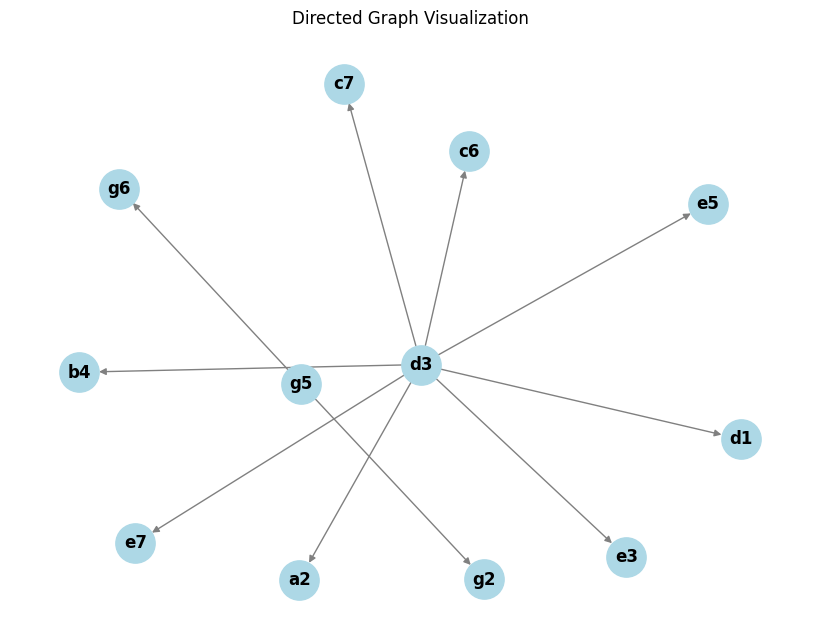

defaultdict(<class 'set'>, {'d3': {'e7', 'c6', 'd1', 'e5', 'e3', 'b4', 'c7', 'a2'}, 'g5': {'g6', 'g2'}})


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_directed_graph(graph):
    G = nx.DiGraph()
    
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, font_weight='bold', edge_color='gray', arrows=True)

    edge_labels = {edge: '' for edge in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Directed Graph Visualization")
    plt.show()

visualize_directed_graph(directed_graph)
print(directed_graph)

## Experimenting with New Pairwise Sensitivity Method

In [46]:
from IPython.display import Image, display
import cairosvg
import cv2
import svg_custom.svg_custom as svg_custom 
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy

In [48]:
def generate_heatmap(board, pos1, pos2):
    """
    Generates heatmap for related pieces (pairs)
    """
    
    # Related pieces
    heatmap = np.zeros((8, 8))
    row_1, col_1 = pos_to_index_mapping(pos1)
    row_2, col_2 = pos_to_index_mapping(pos2)
    heatmap[row_1, col_1] = 1
    heatmap[row_2, col_2] = 1
    heatmap = np.flipud(heatmap)
    

    #### Original board
    svg = svg_custom.board(board)

    with open('svg_custom/board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')

    # original board as a numpy array
    board_array = cv2.imread('svg_custom/board.png')

    threshold = 1 # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)

    cv2.imwrite("svg_custom/board.png", board_array)
    print('------------===============------------===============\n\n')
    display(Image('svg_custom/board.png'))
    print('\n\n------------===============------------===============')

13.45
------------===============------------===============




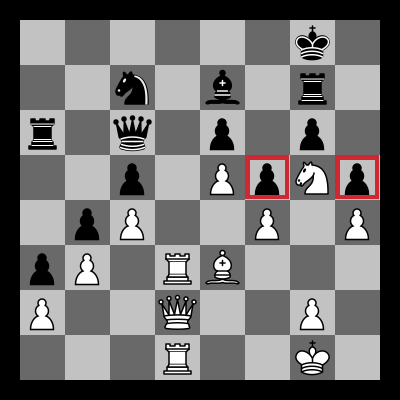



------------===============------------===============
21.689999999999998
------------===============------------===============




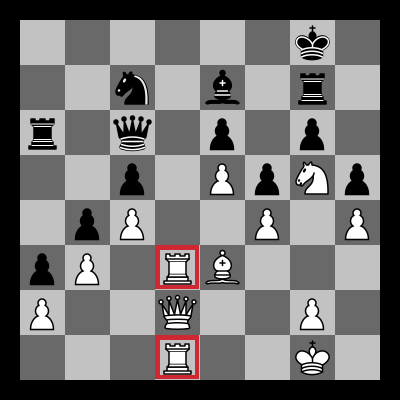



------------===============------------===============
25.549999999999997
------------===============------------===============




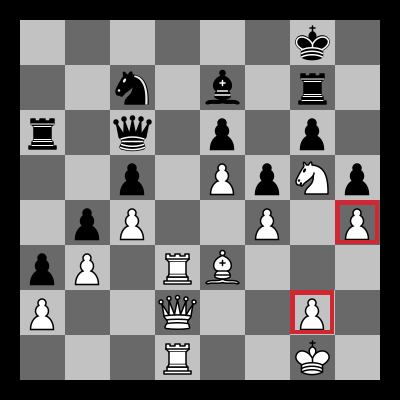



------------===============------------===============
25.57999999999999
------------===============------------===============




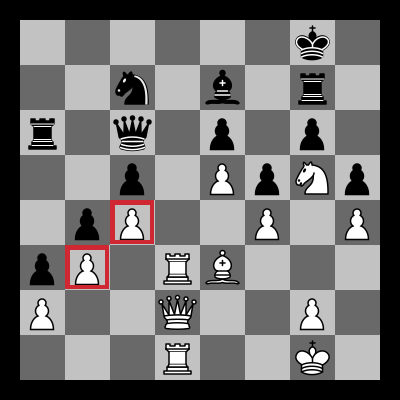



------------===============------------===============
25.660000000000007
------------===============------------===============




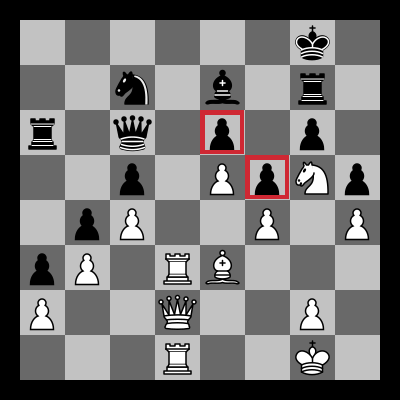



------------===============------------===============
26.989999999999995
------------===============------------===============




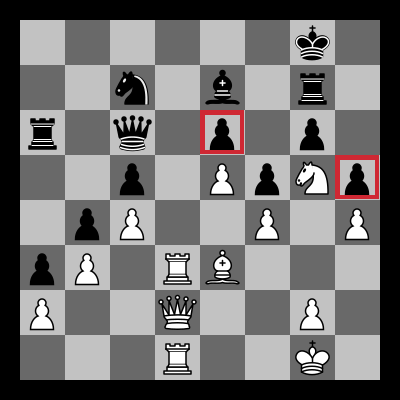



------------===============------------===============
27.179999999999993
------------===============------------===============




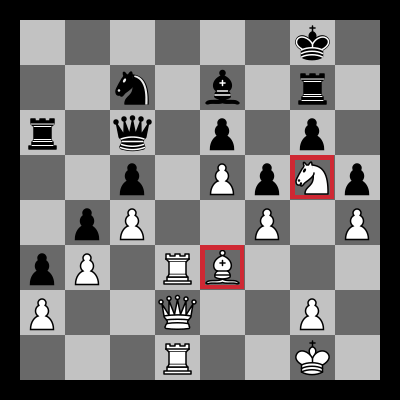



------------===============------------===============
28.300000000000004
------------===============------------===============




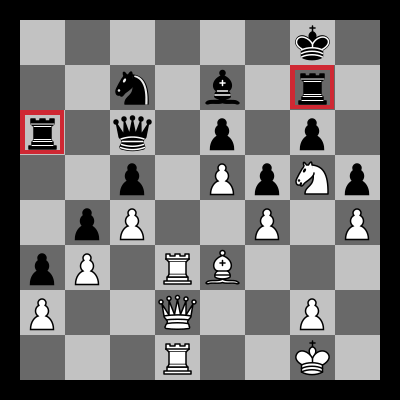



------------===============------------===============
29.229999999999993
------------===============------------===============




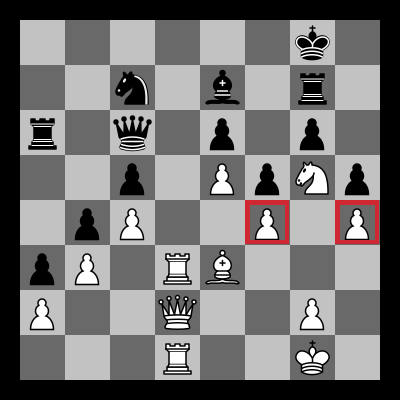



------------===============------------===============
29.629999999999995
------------===============------------===============




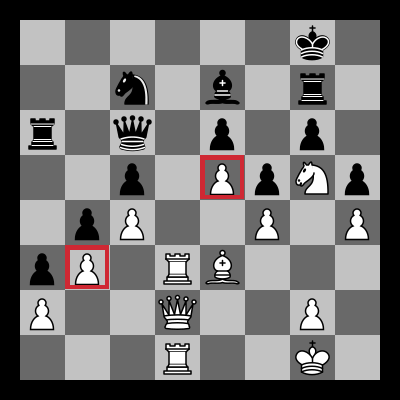



------------===============------------===============


In [52]:
#####################################################
# true = sum over all actions with abs(delta) || false = KL divergence
sum_technique = True
print_top_n_matches = 10
#####################################################

pairwise_sensitivity = {}
all_pieces_removed = perturbation_to_qvals.keys()

for piece_1 in all_pieces_removed:
    for piece_2 in all_pieces_removed:
        if (piece_1 == piece_2):
            pairwise_sensitivity[(piece_1, piece_2)] = float('inf')
        else:
            valid_actions_perturb_1 = set(perturbation_to_qvals[piece_1][0].keys())
            valid_actions_perturb_2 = set(perturbation_to_qvals[piece_2][0].keys())
            intersection_actions = valid_actions_perturb_1.intersection(valid_actions_perturb_2)

            curr_sensitivity = 0
            if (sum_technique):
                # Uses sum technique
                for action in intersection_actions:
                    delta_1 = perturbation_to_qvals[piece_1][1][action] - perturbation_to_qvals[piece_1][0][action]
                    delta_2 = perturbation_to_qvals[piece_2][1][action] - perturbation_to_qvals[piece_2][0][action]
                    curr_sensitivity += abs(delta_1-delta_2)
            else:
                # KL divergence technique
                distribution_1_after = [perturbation_to_qvals[piece_1][1][action] for action in intersection_actions]
                distribution_2_after = [perturbation_to_qvals[piece_2][1][action] for action in intersection_actions]

                distribution_1_after = np.array(distribution_1_after)
                distribution_2_after = np.array(distribution_2_after)

                distribution_1_after = softmax(distribution_1_after)
                distribution_2_after = softmax(distribution_2_after)

                curr_sensitivity = entropy(distribution_1_after, distribution_2_after)
            
            pairwise_sensitivity[(piece_1, piece_2)] = curr_sensitivity

sorted_pairwise_sensitivities = [(key, value) for key, value in pairwise_sensitivity.items()]
sorted_pairwise_sensitivities.sort(key=lambda x: x[1])

for i in range(0, print_top_n_matches):
    pair = sorted_pairwise_sensitivities[i*2]
    positions, value = pair
    print(value)
    generate_heatmap(board, positions[0], positions[1])